In [4]:
import site
site.addsitedir('coding_tools/MLIC/MLICPP')
site.addsitedir('coding_tools')

In [56]:
import os
from PIL import Image
import io
import math
import torch
import struct
import numpy as np
from tempfile import mkstemp
from torchvision import transforms
from coding_tools.TCM.models import rgb2yuv, yuv2rgb, run_command
from coding_tools.utils.timer import Timer
import time
from coding_tools.register import register_tool
from coding_tools.coding_tool import TraditionalCodingToolBase

from PIL import Image
import abc

# 实现的传统编码工具放在这里


@register_tool("VTM")
class VTMTool(TraditionalCodingToolBase):
    def __init__(self):
        self.encoder_path = "../VVCSoftware_VTM/bin/EncoderAppStatic"
        self.decoder_path = "../VVCSoftware_VTM/bin/DecoderAppStatic"
        self.config_path = "../VVCSoftware_VTM/cfg/encoder_intra_vtm.cfg"

    def compress_block(self, img_block: np.ndarray, q_scale: float) -> bytes:
        q_scale = math.ceil(q_scale * 63)
        if not 0.0 <= q_scale <= 63.0:
            raise ValueError(f"Invalid quality value: {q_scale} (0,63)")
        bitdepth = 8
        arr = img_block
        fd, yuv_path = mkstemp(suffix=".yuv")
        out_filepath = os.path.splitext(yuv_path)[0] + ".bin"
        arr = arr.transpose((2, 0, 1))
        c, h, w = arr.shape
        rgb = arr.astype(np.float32) / (2**bitdepth - 1)
        arr = rgb2yuv(rgb)
        arr = np.round(arr * (2**bitdepth - 1)).astype(np.uint8)
        return arr

    def decompress_block(self, arr, h: int, w: int) -> torch.Tensor:
        header_length = struct.calcsize("2i")

        bitdepth = 8
        rec_arr = arr
        rec_arr = rec_arr.reshape((3, h, w))
        rec_arr = rec_arr.astype(np.float32) / (2**bitdepth - 1)
        rec_arr = yuv2rgb(rec_arr)
        rec = np.round((rec_arr.clip(0, 1).transpose(1, 2, 0) * 255.0)).astype(np.uint8)

        return rec

In [57]:
h = 128
w = 128
img_block = np.random.randint(0, 256, (h, w, 3))

In [58]:
tool = VTMTool()
yuv = tool.compress_block(img_block, 0)

In [59]:
img_block_rec = tool.decompress_block(yuv, h, w)

In [60]:
img_block_rec[:10,0,0]

array([  7, 230, 148, 109, 235, 145,  25, 219, 240, 223], dtype=uint8)

In [61]:
img_block[:10,0,0]

array([  6, 230, 148, 109, 235, 145,  26, 219, 240, 222])

In [62]:
mse = np.mean((img_block - img_block_rec) ** 2) / (255**2)
psnr = -10*np.log10(mse)
psnr

53.00121730712158

In [4]:
X = [0.122, 0.123, 0.129, 0.117, 0.080, 0.050]
Y = [44.00, 43.90, 43.76, 43.50, 42.20, 40.59]

X2 = [0.121, 0.110, 0.080]
Y2 = [43.98, 43.40, 42.43]

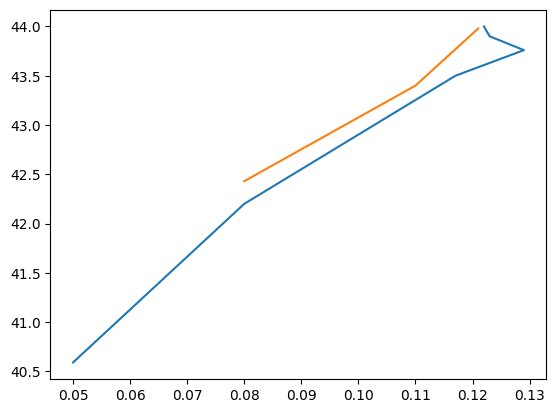

In [5]:
plt.plot(X, Y)
plt.plot(X2, Y2)

In [18]:
import numpy as np
A = np.array([22.59345406, 51.27039951, 46.48372633, 42.75860622, 14.93995604])
B = np.array([1.0000454, 8.3890561, 8.3890561, 8.3890561, 1.0000454])

def f(x):
    return np.sum(A*(B ** (-x/1000)))

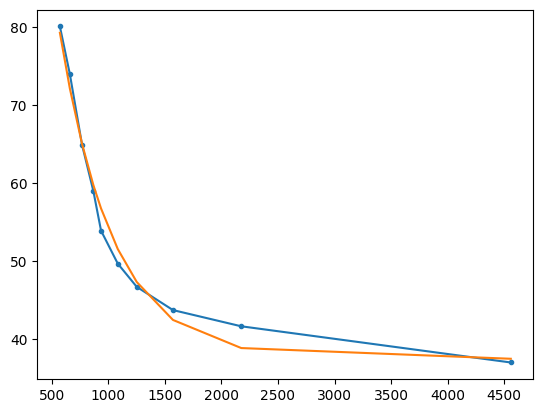

In [19]:
plt.plot(X, Y, marker='.')
plt.plot(X, [f(x) for x in X])